In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import decoupler
import pandas as pd
import numpy as np
import random
import sc_toolbox
import scipy

from scipy.sparse import csr_matrix, isspmatrix
from anndata2ri import converter
from datetime import datetime

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

In [3]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import visualise as vs
from src.utils import utils as us
%load_ext autoreload
%autoreload 2

In [4]:
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
time_start = datetime.now()
%load_ext rpy2.ipython
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
%%R
source(here::here('src/modules/DEG.R'))

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: limma
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


# Load Data

In [6]:
adata = sc.read(config.PATHS.LOGS/'Norm.h5ad')

print(adata.shape)
print('isspmatrix:', isspmatrix(adata.X))


print('Loaded Filtered AnnData object: number of cells', adata.n_obs)
print('Loaded Filtered AnnData object: number of genes', adata.n_vars) 
print('Available metadata for each cell: ', adata.obs.columns)

(27809, 15235)
isspmatrix: True
Loaded Filtered AnnData object: number of cells 27809
Loaded Filtered AnnData object: number of genes 15235
Available metadata for each cell:  Index(['timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2',
       'cluster', 'timepoint_mapped', 'batch', 'dataset', 'isHuman', 'isESC',
       'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo',
       'QC_doublets', 'n_genes', 'n_counts'],
      dtype='object')


In [7]:
adata.obs['time'] = adata.obs.timepoint_mapped.apply(
    lambda x: 'd{}'.format(x)).copy()
adata.obs['isHuman'] = adata.obs.line.apply(
    lambda x: x.lower() in config.HUMANS).copy()

In [8]:
adata.obs['sample'] = adata.obs.line.astype(str) \
    + '_' + adata.obs.batch.astype(str) \
    + '_' + adata.obs.timepoint_mapped.astype(str)
obs_to_keep = ["sample", "cluster", "batch", "line", "time", "isHuman"]

In [9]:
if config.PROTO.SUBSET.USE_HIGHLY_VARIABLE:
    adata = adata[:, adata.var.highly_variable]
adata.X = adata.layers["counts"].copy()

# Exclude

In [10]:
idxs = np.prod([
    adata.obs.timepoint_mapped.apply(
        lambda x: x in config.PROTO.SUBSET.TIMEPOINTS),
], axis=0, dtype=np.bool_)
selected = adata[idxs, :].copy()
selected.obs.head()

,timepoint,line,10X_date,clusters,tSNE_1,tSNE_2,cluster,timepoint_mapped,batch,dataset,...,total_counts,total_counts_mito,pct_counts_mito,total_counts_ribo,pct_counts_ribo,QC_doublets,n_genes,n_counts,time,sample
AAACCTGAGTCCGTAT-4.d5_409b2_171212,d5,409b2,171212,C5,48.413219,-12.483613,C5,5,171212_b0,EMATB,...,4350,84,1.931034,788,18.114943,0.027168,1870,4350,d5,409b2_171212_b0_5
AAACCTGGTATCTGCA-4.d5_409b2_171212,d5,409b2,171212,C5,86.033093,-7.297135,C5,5,171212_b0,EMATB,...,2980,39,1.308725,550,18.456376,0.060618,1374,2980,d5,409b2_171212_b0_5
AAACCTGTCGTTGCCT-4.d5_409b2_171212,d5,409b2,171212,C7,34.884410,62.724772,C7,5,171212_b0,EMATB,...,8534,182,2.132646,2403,28.157956,0.030230,2537,8534,d5,409b2_171212_b0_5
AAACGGGCAATCGAAA-4.d5_409b2_171212,d5,409b2,171212,C7,28.472086,56.683741,C7,5,171212_b0,EMATB,...,13953,354,2.537089,4262,30.545402,0.054435,3559,13953,d5,409b2_171212_b0_5
AAACGGGCAATGGACG-4.d5_409b2_171212,d5,409b2,171212,C5,53.433417,-18.701272,C5,5,171212_b0,EMATB,...,2645,47,1.776938,551,20.831758,0.050885,1332,2645,d5,409b2_171212_b0_5


In [11]:
selected = selected[
    selected.obs.cluster.apply(
        lambda x: x in 
        config.PROTO.SUBSET.EMATB_CLUSTERS)].copy()
selected

AnnData object with n_obs × n_vars = 22776 × 7000
    obs: 'timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2', 'cluster', 'timepoint_mapped', 'batch', 'dataset', 'isHuman', 'isESC', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'QC_doublets', 'n_genes', 'n_counts', 'time', 'sample'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'line_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_triku'
    varm: 'PCs'
    layers: 'counts', 'lognormcounts'
    obsp: 'connectivities', 'distances'

In [12]:
mapc = { 'C2': 0, 'C3': 1, 'C4': 2, 'C5': 2, 'C6': 2, 'C7': 2 }
selected.obs['group'] = selected.obs.cluster.apply(
    lambda x: 'G{}'.format(mapc[x]))

In [13]:
if config.PROTO.PSEUDO_BULK.TYPE == 'decoupler':
    adata_pb = decoupler.get_pseudobulk(
        selected, 'sample', 'cluster', selected.obs,
        min_cells=config.PROTO.GLM.MIN_CELLS,
        mode=config.PROTO.GLM.PSEUDOBULK_MODE)
assert config.PROTO.PSEUDO_BULK.TYPE == 'decoupler', 'NOT SUPPORTED ATM'

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/anndata/_core/anndata.py:447: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


use cluster or group?
whether samples in 

# edgeR

In [14]:
filter_low_counts = config.PROTO.GLM.FILTER
include_time = config.PROTO.GLM.INCLUDE_TIME

In [15]:
%%time
%%R -i adata_pb -i filter_low_counts -i include_time -o tt

outs <- degs(adata_pb, filter_low_counts, include_time)
myContrast <- makeContrasts(
    "isHumanTRUE.d5-isHumanFALSE.d5", levels=outs$y$design)
qlf <- glmQLFTest(outs$fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: De

In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


CPU times: user 25.5 s, sys: 497 ms, total: 26 s
Wall time: 26.2 s


In [16]:
factors = [ 'd{}'.format(t) for t in config.PROTO.SUBSET.TIMEPOINTS ]

In [17]:
%%R -i factors -o qlfs

qlfs <- list()
for (factor in factors) {
    contrast <- paste0(
        "isHumanTRUE.", factor, "-isHumanFALSE.", factor)
    myContrast <- makeContrasts(contrast, levels=outs$y$design)
    qlf <- glmQLFTest(outs$fit, contrast=myContrast)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    tt <- tt$table
    qlfs[[factor]] <- tt
}

In [18]:
# add the table to .uns for each cell type
ranks = dict()
for postfix, tt in qlfs.items():
    tt["gene_symbol"] = tt.index
    tt["time"] = postfix
    sc_toolbox.tools.de_res_to_anndata(
        selected,
        tt,
        groupby="time",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + postfix,
    )
    ranked = sc.get.rank_genes_groups_df(
        selected, group=postfix, key="edgeR_{}".format(postfix))
    ranks[postfix] = ranked.sort_values(by='scores')
    

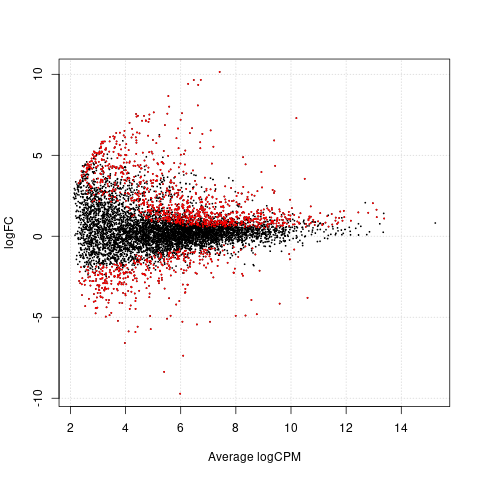

In [19]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR< .01)])

# Visualisation

In [20]:
selected.X = selected.layers["counts"].copy()
sc.pp.normalize_total(selected, target_sum=1e6)
sc.pp.log1p(selected)

# Day 5th

Plotting 736 genes...


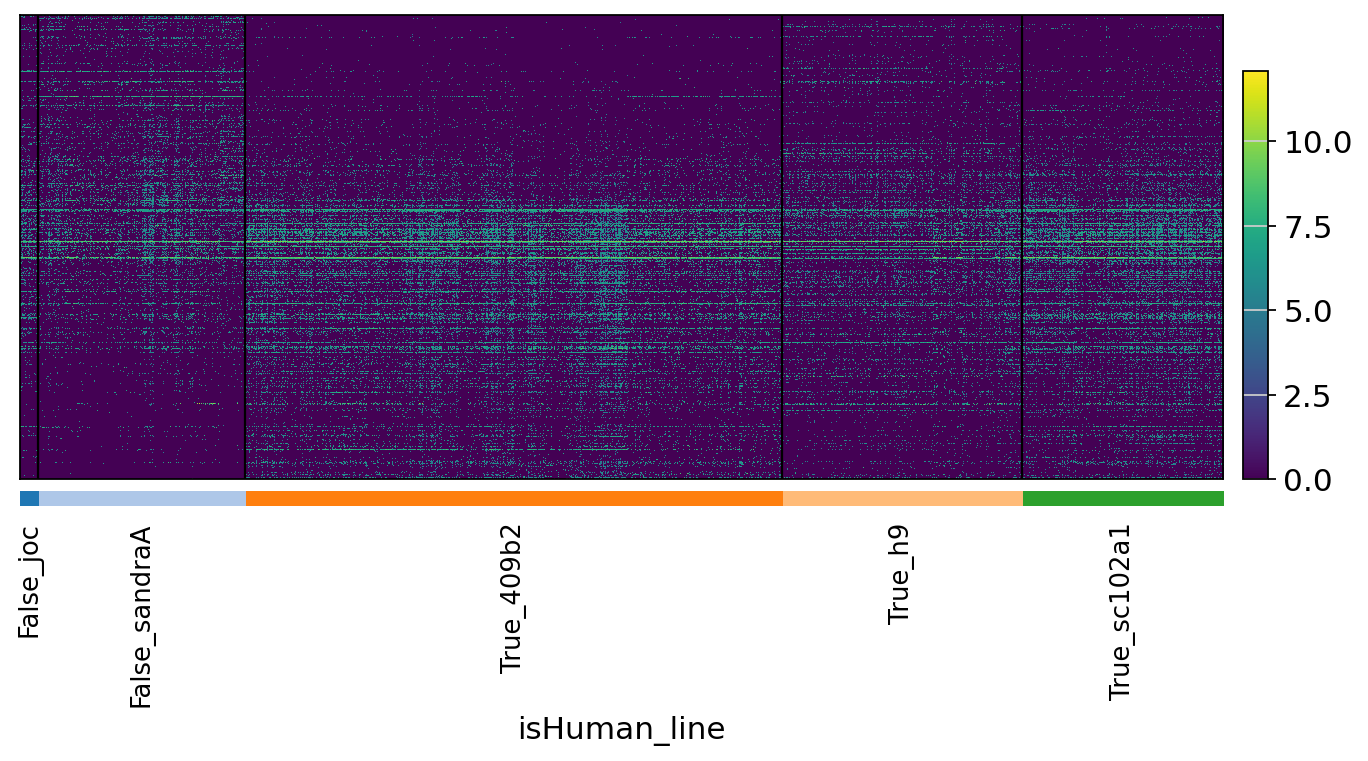

In [21]:
postfix = 'd5'
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_{}".format(postfix))

In [22]:
ranks[postfix].to_csv(config.PATHS.LOGS/'w1_markers.csv')
print(' '.join(markers))

BX255923.3 AJAP1 AC074183.4 CTSF RIT2 GSTT2B SLC32A1 GAD2 C5orf63 OPRK1 WDR72 NEMP1 CRYBA1 RORA-AS1 DNM1P35 PWP2 LYNX1 RP11-109E12.1 YAP1 CDX2 SSTR1 GRM7 ANKRD1 MEIOB ADAMTS6 GRIA1 RP11-506M13.3 NDNF AC005523.2 SPDYC AC131056.3 LA16c-380H5.6 RP11-110I1.6 RP13-39P12.3 COL4A5 COMT ERBB4 MTRNR2L10 DES MEIG1 LIMD1 PTH1R TUBB8 LL22NC03-32F9.1 TRABD2A XCL1 DEPDC1 LINC00152 NPIPB15 AC005037.3 SLC2A14 FCGBP RP11-89K21.1 PAX2 FOXD4 PGM5P3-AS1 RASL11A AC138969.4 ZNF221 RP11-357H14.17 GDF15 TM4SF19-AS1 PRRX2 KLF5 SOX21 CADPS2 NALCN CSPG4 ITGA6 HAPLN4 MAMDC2 CSMD3 SH2D3A TMEM132C TH SP140L BMP7 KIF18B PRLR RRM2 PTPRT MYO3A KISS1 TRIM22 SEPP1 ENPEP C18orf42 POU5F1B ZNF528 MTRNR2L12 MYO5C RAB37 RDM1 HIST1H1D LTC4S ITGB5 ZNF578 PEAR1 HEYL RP11-430G17.3 ASCL1 HS3ST4 RLN2 LCAT LRP2 TUBA1C RP11-380D23.2 GPC4 NMRK2 SLC6A11 WNT4 CTC-360G5.9 SFRP4 VWDE HSPA1B ROBO3 TEX22 SLC18A2 CTD-2021H9.3 DCAF6 TRIM25 POLQ FOSL1 FZD10 PRIMA1 CES1 RAD54L GAD1 TFPI ATP5EP2 HSD11B2 SRRM4 RP11-480C16.1 MTRNR2L1 C11orf70 DHD

# Week 2

Plotting 560 genes...


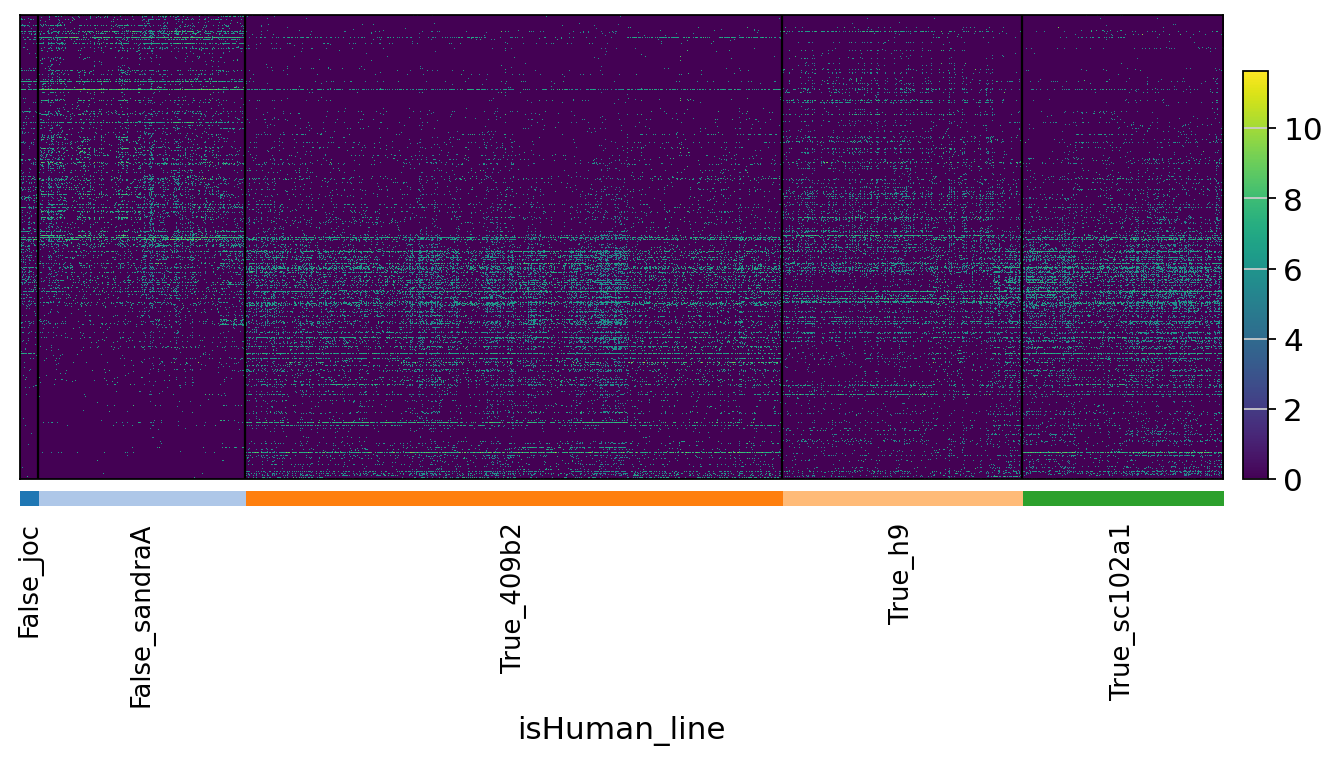

In [23]:
postfix = 'd14'
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_{}".format(postfix))

In [24]:
ranks[postfix].to_csv(config.PATHS.LOGS/'w2_markers.csv')
print(' '.join(markers))

GSTT2B NEMP1 BX255923.3 PGM5P3-AS1 PRSS3 AC074183.4 C5orf63 TUBB8 KLF5 FCGBP SYK C11orf70 MEIOB XCL1 MTRNR2L10 HOXA3 RP11-109E12.1 PRIMA1 SVIL-AS1 TUBA1C TRABD2A B3GLCT NPIPB15 UTS2 MCPH1-AS1 CEMIP FAM46B ATP5EP2 UHRF1 MEIG1 PAX7 AC131056.3 CTD-2021H9.3 DTL MTRNR2L1 STK26 CFAP77 PBK SPDYC CTSF IRAK1 EMP1 MKI67 MCM10 AC010884.1 SP8 RP11-506M13.3 CTB-193M12.5 DES SLC2A14 HOXA5 TEX22 KIF2C FOXB1 HOXA7 CCDC81 ADGRG6 CES1 CLDN10 RORA-AS1 CDC45 OTX1 RP4-621F18.2 LA16c-380H5.6 FAM162B NMRK2 CHKB-AS1 ERCC6L CRYBA1 DLGAP5 CENPA ARPIN SPHKAP GDPD2 DDIAS NTF4 HOXA-AS2 AC005523.2 CDC20 TROAP MTRNR2L12 CLDN1 MYBL2 DHDH RAB38 E2F2 ECHDC3 RIT2 TK1 NBEAL1 RRM2 SP5 RASL11A FST RP6-99M1.3 KIF18B CKAP2L DMC1 DDIT4L GSAP SLC32A1 HOXB-AS1 RP11-255M2.3 PTTG1 TNMD ANXA11 GLI1 ANKRD33B AC138969.4 HOXA10 TNFRSF11B CTC-360G5.9 TXNRD2 ESPL1 KIF4A WDR97 MAP1LC3B2 CADPS2 CH507-154B10.1 RAD51 UBE2C RP11-165A20.3 FOXD4 KCP RP1-120G22.11 MYL4 TMEM263 MTFR2 BRCA2 MTRNR2L8 NSUN7 SP140L BMP8B IL13RA1 ADCY8 RP11-573D15.2

# 28 Days Later

Plotting 466 genes...


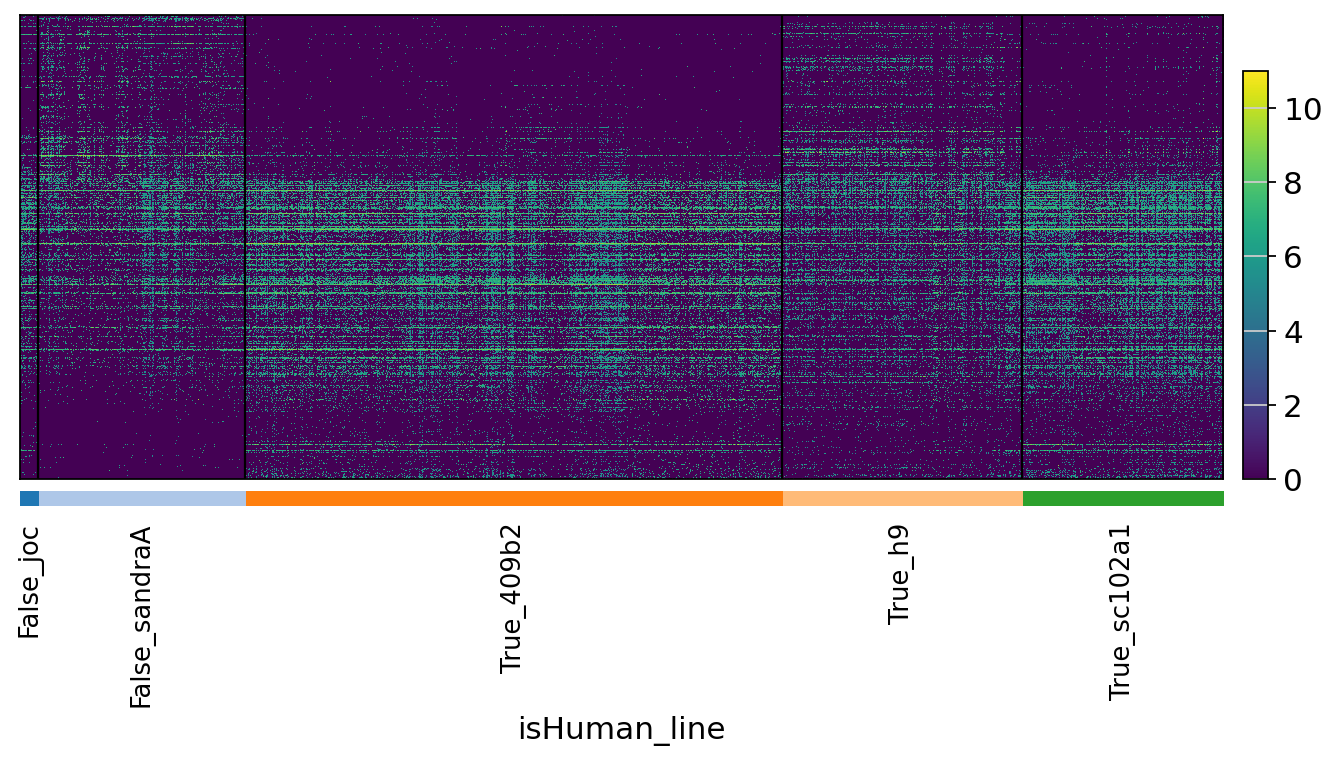

In [25]:
postfix = 'd28'
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_{}".format(postfix))

In [26]:
ranks[postfix].to_csv(config.PATHS.LOGS/'w4_markers.csv')
print(' '.join(markers))

MEIOB AJAP1 CTSF GSTT2B BX255923.3 AC074183.4 PGM5P3-AS1 OTX2 PWP2 TMEM132C MMRN1 TUBA1C CHL1 RBM47 NPY TEX22 ATP6V1C2 RSPO1 GJA1 MTRNR2L12 CLDN1 COL4A6 FOXJ1 CYP1B1 CYP26A1 PALMD SLC2A14 HIST1H1D MTRNR2L8 CFI NUF2 RGCC WLS MEIG1 HSD17B2 ACSF2 SPDYC RP11-15H20.7 RP11-109E12.1 FCGBP MYBL2 MTRNR2L10 ITGA5 DSP RAB38 CA2 GPX8 ZIC3 TRABD2A ATP1A2 RORA-AS1 COL4A5 YAP1 LAMB2 TK1 HLA-E CRIP1 ADAMTS16 LXN RASL11A CDK2 NPIPB15 RP11-255M2.3 LRP2 GDPD2 KIF20A TAGLN KLF5 CASP7 COL9A1 ZIC2 AJUBA RP13-39P12.3 NEMP1 TTK KCNJ4 ZIC5 LDLRAP1 MDFIC HMGA2 EPHA2 DMRTA2 EMX2 CCL2 MCPH1-AS1 RP11-178C3.2 RHOJ NR2F2-AS1 PRRX1 FLNC C5orf63 MGST1 UBE2C ECHDC3 CHRDL1 RSPO3 BACE2 CAPN6 EFS GRAMD3 OTX1 ZIC1 PROM1 C11orf70 ZNF221 NEIL3 ERICH5 THBS1 DKKL1 CRYBA1 PAPSS2 LYPD6 SFRP1 MYO1E LHX2 VRK2 ENO3 S100A11 RNF135 MAMDC2 IMPA2 ENPP2 AC005523.2 CHKB-AS1 IGFBP2 AC002454.1 RBPMS TBL1X SDC2 PLEKHG4B LRRC17 IRAK1 NR2F2 NOTCH3 AGTRAP CSRP2 ARHGEF6 MFGE8 SPARC IL13RA1 ANXA11 NBEAL1 CENPW LRP10 AC113189.5 CASP6 GLDC ZNF596 

# Week 5

Plotting 871 genes...


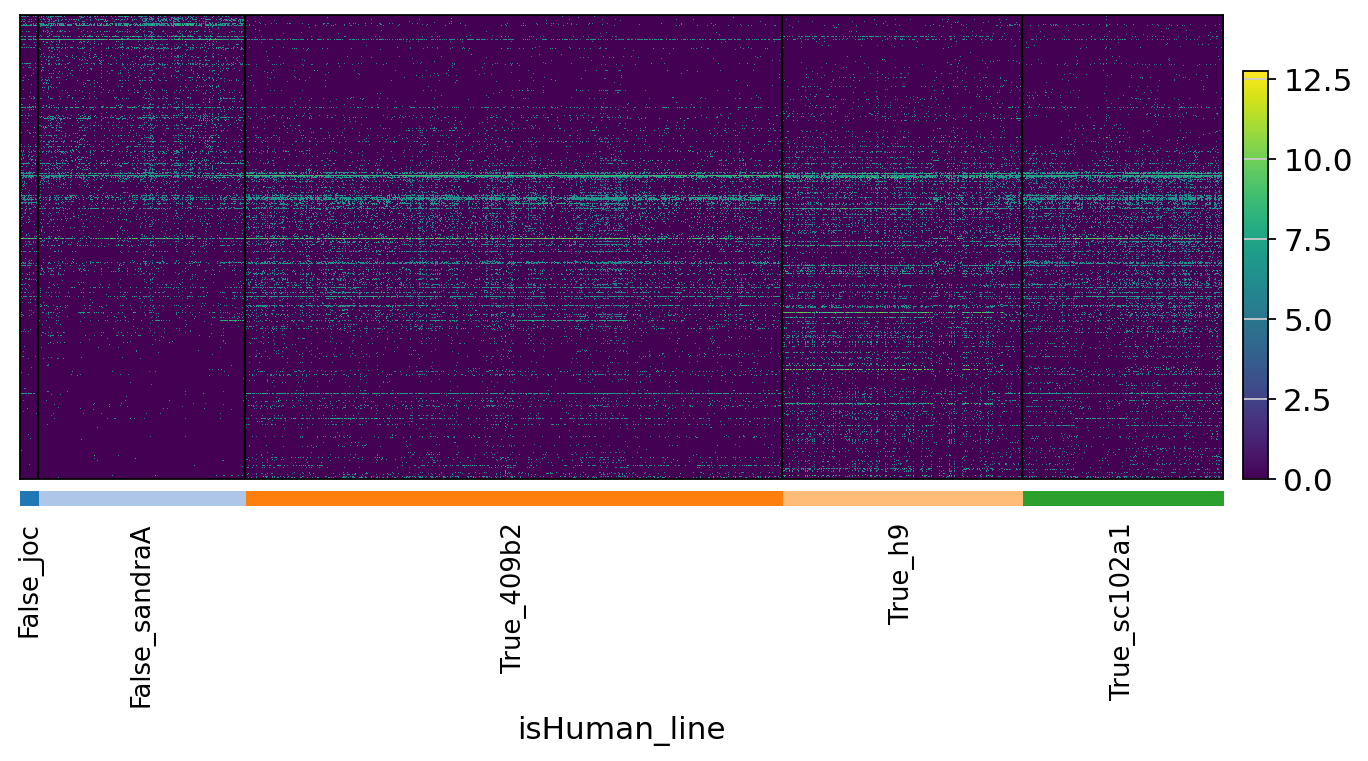

In [27]:
postfix = 'd35'
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_{}".format(postfix))

In [28]:
ranked.to_csv(config.PATHS.LOGS/'w5_markers.csv')
print(' '.join(markers))

BX255923.3 AC074183.4 MEIOB PGM5P3-AS1 RP11-255M2.3 XCL1 MTRNR2L10 RP11-109E12.1 NPIPB15 GSTT2B NEMP1 FCGBP TRABD2A C5orf63 BGN MTRNR2L1 MEIG1 MTRNR2L8 PGAM4 MTRNR2L12 SPDYC RP11-357H14.17 TEX22 CYP1B1 TUBB8 HOXA10 HOXA7 SFRP4 CTB-193M12.5 RP11-15H20.7 AC005523.2 ATP5EP2 AC010884.1 SP140L COL8A1 ADGRG6 KCNJ4 PVALB ZNF221 SULT1E1 TUBA1C SLC2A14 FAP RP13-39P12.3 KLF5 NBEAL1 CEMIP CFI RP11-110I1.6 RP11-89K21.1 HOXC9 HSD17B2 CTC-360G5.9 TNFRSF10D MCPH1-AS1 CTSF LYNX1 RP11-506M13.3 TRAC RP11-491F9.1 FOXD4 CHKB-AS1 ADGRL2 RP11-354E11.2 CTD-2021H9.3 TGFA RFPL2 SLC32A1 RORA-AS1 EMP1 CLDN1 PRSS3 AC005037.3 IGFBP7 UHRF1 P3H2 AC138969.4 NHSL2 RP11-60L3.6 B3GLCT DNM1P35 AC131056.3 NPIPB6 LRRC17 ESRRB RP11-81A22.5 SOSTDC1 ELN WDR97 RP13-516M14.4 RP6-99M1.3 MAP1LC3B2 IRAK1 EIF5AL1 ZNF596 DGCR9 COL12A1 ENG DHDH HOXA5 CRYBA1 RP11-219A15.1 RP11-178C3.2 CLDN11 ANOS1 LIF SYTL2 LA16c-380H5.6 HOXB9 SALL3 ITGA1 C7 PLA2G7 SYNPR SP8 CFAP77 OLFML2A IL13RA1 TNFAIP6 ITGA4 RLN2 ECHDC3 AC113189.5 DNM3OS DLX2 THSD4